Import Modules

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import decode_data as dd

In [2]:
## Get Data
[bytes,transactions,transaction_time,cell_register_reads,pec,local_pec,pec_ok,cell_v,cell_times] = dd.get_decoded_data()

Decoding...
7.19 %
14.38 %
21.58 %
28.77 %
35.96 %
43.15 %
50.35 %
57.54 %
64.73 %
71.92 %
79.12 %
86.31 %
93.50 %
100.0 %

Bad edges:  39


c:\Users\Marco.Nunez\Documents\My Temp\LTC-comms\decode_data.py:161: RuntimeWarning: overflow encountered in scalar multiply
  local_pec.append(np.array(remainder * 2).astype(np.uint16))


Total 3681 successful PEC checks -- 13.109 %


In [3]:
## Omar's Method
kNumCells = 12
kNumRetries = 3
kResampleSize = 2340

Xtransmitted = np.swapaxes(cell_v.reshape((kResampleSize,kNumRetries,kNumCells)), 0, 1)

Xbar = np.mean(Xtransmitted, axis=0)

Xdiff = Xtransmitted - np.array([Xbar,Xbar,Xbar])


In [4]:
## Generate resutls
Xgood_flag = Xdiff <= 11648
Xgood = np.multiply(Xtransmitted, Xgood_flag)

Xans = np.divide(np.sum(Xgood, axis=0), np.sum(Xgood_flag, axis=0))


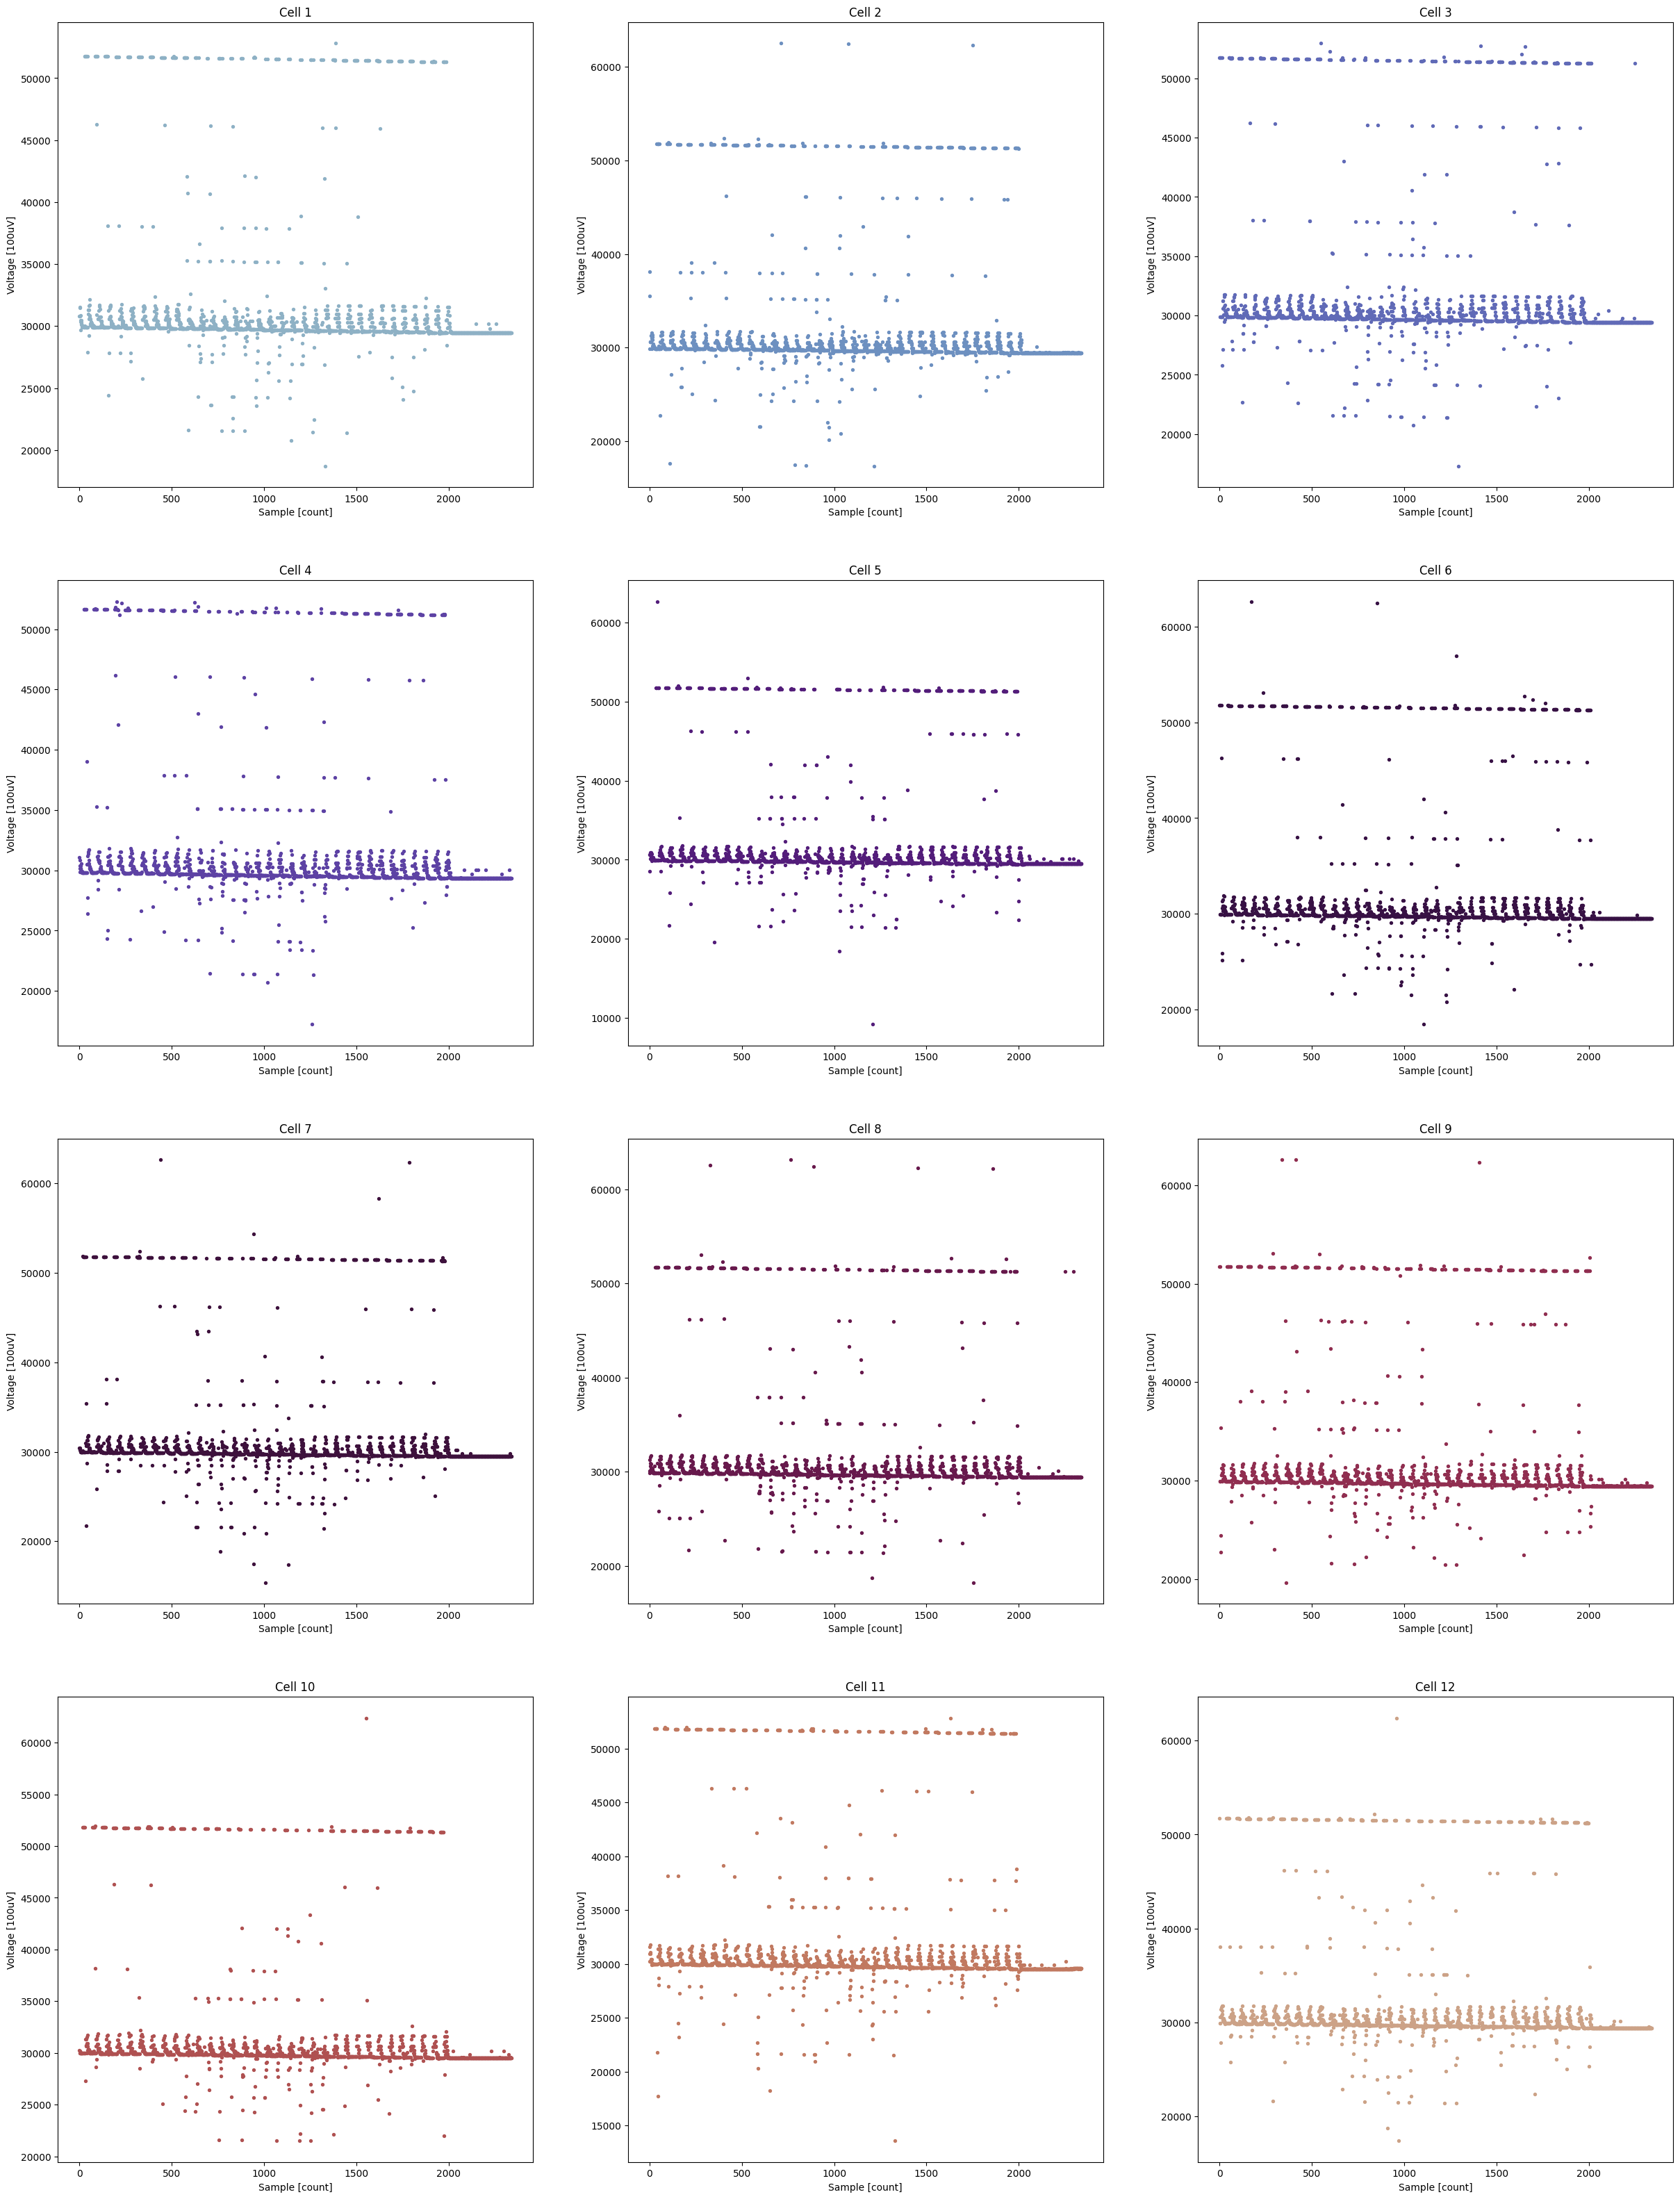

In [6]:
## Plot of Processed Data
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(30, 40))
colormap = mpl.colormaps['twilight'].resampled(120)
c = colormap(np.linspace(0,1,16))

t = np.arange(0, Xans.shape[0])


for i in range(0, kNumCells):
    plot = axs[int(i/3),int(i%3)]
    plot.scatter(t, Xans[:,i], s=8, color=c[i+2])
    plot.set_xlabel("Sample [count]")
    plot.set_ylabel("Voltage [100uV]")
    name = "Cell " + str(i+1)
    plot.set_title(name)